## Import libraries

In [52]:
import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from torch.optim.lr_scheduler import ReduceLROnPlateau

from sklearn.preprocessing import StandardScaler

has_mps = torch.backends.mps.is_built()
device = "mps" if has_mps else "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

Using device: cpu


In [53]:
# HYPERPARAMETERS
SEQUENCE_SIZE = 3
dataset_path = "ParkingDataDataset.txt"
split_ratio = 0.7 # 70% training, 30% testing
batch_size = 32

# Regarding training loop
epochs = 1000
early_stop_count = 0
min_val_loss = float('inf')
learning_rate = 0.001

## Load dataset

In [54]:
# read text file into pandas DataFrame
df = pd.read_csv(dataset_path, sep="\t")
df.head(10)

,DateTime,Car ID,Vehicle,VType,Day,ReqT,EntHr,EntMin,ExitHr,ExitMin,...,Tries,DFS,IdleVeh,tFree,z1Free,z2Free,z3Free,z4Free,dReq,Unnamed: 27
0,2022-01-01 08:25:00,936,Student,3,1,406,8,25,8,32,...,1,365,5,93,14,49,8,22,1,NaN
1,2022-01-01 08:25:00,937,Faculty,2,1,1333,8,25,8,47,...,1,354,6,93,14,49,8,22,1,NaN
2,2022-01-01 08:00:00,942,Staff,5,1,8883,8,0,8,0,...,2,672,17,0,0,0,0,0,1,NaN
3,2022-01-01 08:39:00,948,Visitor,1,1,1143,8,39,8,58,...,1,365,12,88,12,46,8,22,1,NaN
4,2022-01-01 08:00:00,983,Student,3,1,7432,8,0,8,0,...,2,672,15,0,0,0,0,0,2,NaN
5,2022-01-01 08:55:00,959,Faculty,2,1,731,8,55,9,8,...,1,354,17,74,3,41,8,22,2,NaN
6,2022-01-01 08:00:00,975,Faculty,2,1,4296,8,0,8,0,...,2,672,12,0,0,0,0,0,2,NaN
7,2022-01-01 09:21:00,977,Student,3,1,95,9,21,9,22,...,1,365,16,60,1,29,8,22,3,NaN
8,2022-01-01 09:16:00,984,Student,3,1,424,9,16,9,23,...,1,354,17,62,1,31,8,22,3,NaN
9,2022-01-01 08:00:00,992,Faculty,2,1,7713,8,0,8,0,...,2,672,14,0,0,0,0,0,6,NaN


In [55]:
df.columns

Index(['DateTime            ', 'Car ID', 'Vehicle', 'VType', 'Day', 'ReqT',
       'EntHr', 'EntMin', 'ExitHr', 'ExitMin', 'TDelay', 'IdleT', 'TBill',
       'Fine', 'PL No.', 'PLZone', 'nFree', 'nFill', 'Tries', 'DFS', 'IdleVeh',
       'tFree', 'z1Free', 'z2Free', 'z3Free', 'z4Free', 'dReq', 'Unnamed: 27'],
      dtype='object')

## Pre-process the dataset

In [56]:
# PREPROCESS THE MAIN DATASET TO GET CLEANED DATA
cleaned_df = df.copy()

# dropping useless columns
cleaned_df.drop('Car ID', inplace=True, axis=1)
cleaned_df.drop('Unnamed: 27', inplace=True, axis=1)
cleaned_df.drop('VType', inplace=True, axis=1)

# dropping useless rows
cleaned_df.drop(cleaned_df[cleaned_df['tFree'] == 0].index, inplace = True)
cleaned_df.drop(cleaned_df[cleaned_df['EntMin'] == 60] .index, inplace = True)

# creating datetime index column
cleaned_df['datetime'] = cleaned_df.iloc[:, 0]
cleaned_df.datetime = pd.to_datetime(cleaned_df.datetime)
cleaned_df.set_index(cleaned_df.datetime)
print('Index Column Created!')

# Sorting the data
cleaned_df = cleaned_df.sort_values(by=['Day', 'EntHr'], ascending=[True, True])

# creating new dataframe for model input
bill_df = cleaned_df.drop(cleaned_df.loc[:, cleaned_df.columns != "TBill"], axis=1)
# bill_df['datetime'] = cleaned_df.datetime
bill_df.set_index(cleaned_df.datetime, inplace=True)
bill_df.head()


Index Column Created!


,TBill
datetime,
2022-01-01 08:25:00,8
2022-01-01 08:25:00,39
2022-01-01 08:39:00,48
2022-01-01 08:55:00,21
2022-01-01 08:49:00,52


In [57]:
# aggregate
ts = bill_df['TBill'].resample('H').sum()
ts = ts.to_frame()
ts.head()

,TBill
datetime,
2022-01-01 08:00:00,4818
2022-01-01 09:00:00,4682
2022-01-01 10:00:00,3459
2022-01-01 11:00:00,4458
2022-01-01 12:00:00,4160


<Axes: xlabel='datetime'>

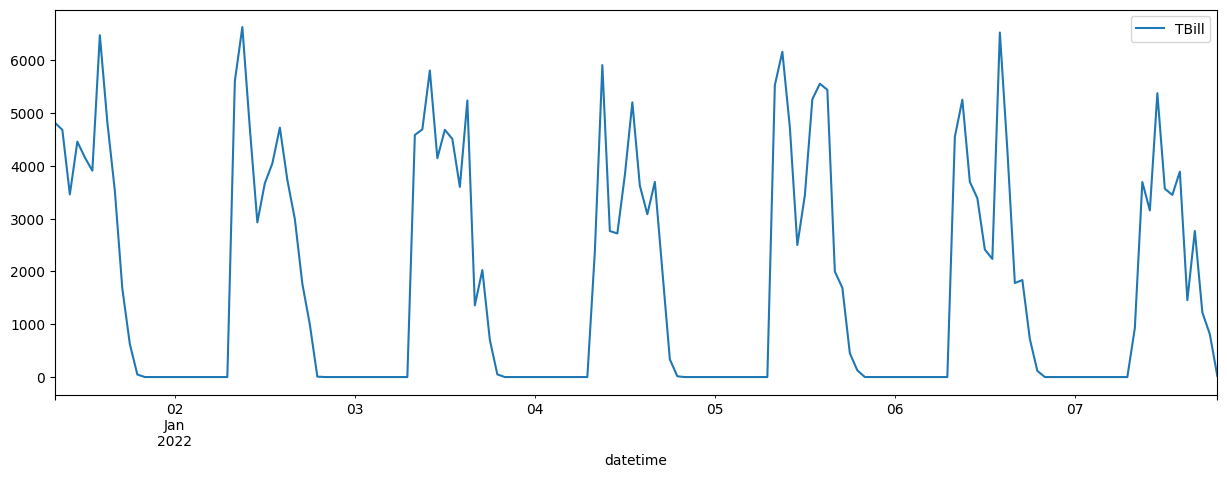

In [58]:
# plotting the aggregated series
ts.plot(figsize=(15, 5))

In [59]:
# SPLIT THE MAIN DATASET INTO TRAIN AND TEST DATASETS
# Determine the split point based on the desired ratio (80% train, 20% test)
split_index = int(split_ratio * len(ts))

# Split the data into training and testing datasets
df_train = ts.iloc[:split_index]
df_test = ts.iloc[split_index:]

In [60]:
# EXTRACT ONLY WHAT'S REQUIRED FROM THE DATASET
bill_train_unscaled = df_train['TBill'].to_numpy().reshape(-1, 1)
bill_test_unscaled = df_test['TBill'].to_numpy().reshape(-1, 1)

scaler = StandardScaler()
bill_train = scaler.fit_transform(bill_train_unscaled).flatten().tolist()
bill_test = scaler.transform(bill_test_unscaled).flatten().tolist()

In [61]:
# Sequence Data Preparation
def to_sequences(seq_size, obs):
    x = []
    y = []
    for i in range(len(obs) - seq_size):
        window = obs[i:(i + seq_size)]
        after_window = obs[i + seq_size]
        x.append(window)
        y.append(after_window)
    return torch.tensor(x, dtype=torch.float32).view(-1, seq_size, 1), torch.tensor(y, dtype=torch.float32).view(-1, 1)

x_train, y_train = to_sequences(SEQUENCE_SIZE, bill_train)
x_test, y_test = to_sequences(SEQUENCE_SIZE, bill_test)

# Setup data loaders for batch
train_dataset = TensorDataset(x_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

test_dataset = TensorDataset(x_test, y_test)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [62]:
print(x_train[:3])
print('-----------------')
print(y_train[:3])
print(x_train.shape)
print(y_train.shape)

tensor([[[1.3506],
         [1.2882],
         [0.7270]],

        [[1.2882],
         [0.7270],
         [1.1854]],

        [[0.7270],
         [1.1854],
         [1.0487]]])
-----------------
tensor([[1.1854],
        [1.0487],
        [0.9331]])
torch.Size([106, 3, 1])
torch.Size([106, 1])


## Convolutional model

In [63]:
class CNNModel(nn.Module):
    def __init__(self, input_size=3, conv_channels=[32, 64, 128, 256], fc_hidden_sizes=[256, 128], output_size=1):
        super(CNNModel, self).__init__()

        # Convolutional layers
        self.conv1 = nn.Conv1d(in_channels=input_size, out_channels=conv_channels[0], kernel_size=3, padding=1)
        self.conv2 = nn.Conv1d(in_channels=conv_channels[0], out_channels=conv_channels[1], kernel_size=3, padding=1)
        self.conv3 = nn.Conv1d(in_channels=conv_channels[1], out_channels=conv_channels[2], kernel_size=3, padding=1)
        self.conv4 = nn.Conv1d(in_channels=conv_channels[2], out_channels=conv_channels[3], kernel_size=3, padding=1)

        # Fully connected layers
        self.fc1 = nn.Linear(conv_channels[3], fc_hidden_sizes[0])
        self.fc2 = nn.Linear(fc_hidden_sizes[0], fc_hidden_sizes[1])
        self.fc3 = nn.Linear(fc_hidden_sizes[1], output_size)

        # Activation functions
        self.relu = nn.ReLU()

    def forward(self, x):
        # Input shape: (batch_size, seq_len, input_size)

        # Convolutional layers
        x = self.relu(self.conv1(x))
        x = self.relu(self.conv2(x))
        x = self.relu(self.conv3(x))
        x = self.relu(self.conv4(x))

        # Global average pooling
        x = F.adaptive_avg_pool1d(x, 1).squeeze()

        # Fully connected layers
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.fc3(x)

        return x

# Instantiate the more complex model
model = CNNModel().to(device)

## Training the model

In [64]:
# Train the model
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
scheduler = ReduceLROnPlateau(optimizer, 'min', factor=0.5, patience=3, verbose=True)

for epoch in range(epochs):
    model.train()
    for batch in train_loader:
        x_batch, y_batch = batch
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)

        optimizer.zero_grad()
        outputs = model(x_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()

    # Validation
    model.eval()
    val_losses = []
    with torch.no_grad():
        for batch in test_loader:
            x_batch, y_batch = batch
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)
            outputs = model(x_batch)
            loss = criterion(outputs, y_batch)
            val_losses.append(loss.item())

    val_loss = np.mean(val_losses)
    scheduler.step(val_loss)

    if val_loss < min_val_loss:
        min_val_loss = val_loss
        early_stop_count = 0
    else:
        early_stop_count += 1

    if early_stop_count >= 5:
        print("Early stopping!")
        break
    print(f"Epoch {epoch + 1}/{epochs}, Validation Loss: {val_loss:.4f}")


Epoch 1/1000, Validation Loss: 0.7083
Epoch 2/1000, Validation Loss: 0.6941
Epoch 3/1000, Validation Loss: 0.6504
Epoch 4/1000, Validation Loss: 0.5745
Epoch 5/1000, Validation Loss: 0.4663
Epoch 6/1000, Validation Loss: 0.4051
Epoch 7/1000, Validation Loss: 0.4442
Epoch 8/1000, Validation Loss: 0.4362
Epoch 9/1000, Validation Loss: 0.3630
Epoch 10/1000, Validation Loss: 0.3637
Epoch 11/1000, Validation Loss: 0.3919
Epoch 12/1000, Validation Loss: 0.4125
Epoch 00013: reducing learning rate of group 0 to 5.0000e-04.
Epoch 13/1000, Validation Loss: 0.4090
Early stopping!


In [65]:
# Evaluation
model.eval()
predictions = []
with torch.no_grad():
    for batch in test_loader:
        x_batch, y_batch = batch
        x_batch = x_batch.to(device)
        outputs = model(x_batch)
        predictions.extend(outputs.squeeze().tolist())

rmse = np.sqrt(np.mean((scaler.inverse_transform(np.array(predictions).reshape(-1, 1)) - scaler.inverse_transform(y_test.numpy().reshape(-1, 1)))**2))
print(f"Score (RMSE): {rmse:.4f}")

Score (RMSE): 1362.9094


## Forecasting

<Axes: xlabel='datetime'>

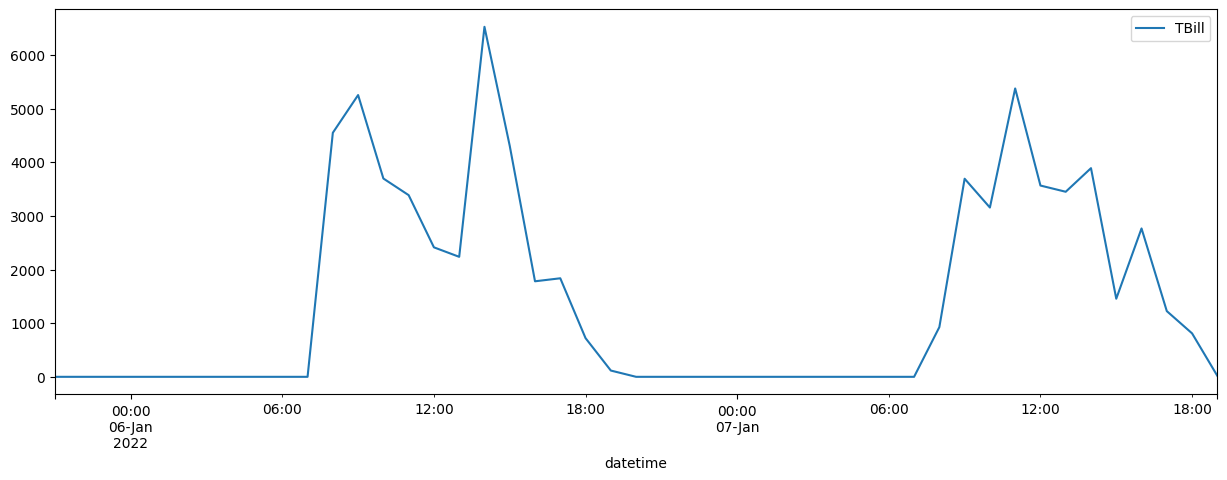

In [66]:
# plotting the aggregated series (ACTUAL TEST DATA)
df_test.plot(figsize=(15, 5))

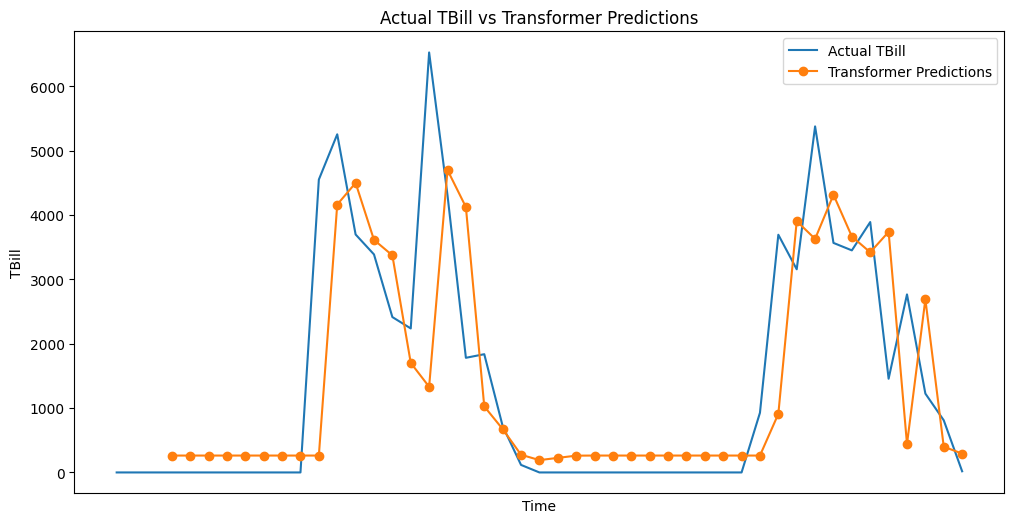

In [67]:
# PLOTTING COMPARISON
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Plotting the actual bill data
plt.figure(figsize=(12, 6))
plt.plot(df_test.index, scaler.inverse_transform(np.array(bill_test).reshape(-1, 1)), label='Actual TBill')

# Plotting the Transformer predictions
model.eval()
all_predictions = []
with torch.no_grad():
    for batch in test_loader:
        x_batch, y_batch = batch
        x_batch = x_batch.to(device)
        outputs = model(x_batch)
        all_predictions.extend(outputs.squeeze().tolist())

# Convert predictions to original scale
all_predictions = scaler.inverse_transform(np.array(all_predictions).reshape(-1, 1))

# Plotting Transformer predictions
plt.plot(df_test.index[SEQUENCE_SIZE:], all_predictions, label='Transformer Predictions', marker='o')

# Formatting the plot
plt.title('Actual TBill vs Transformer Predictions')
plt.xlabel('Time')
plt.ylabel('TBill')
plt.legend()
plt.gca().xaxis.set_major_locator(mdates.YearLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

# Display the plot
plt.show()
